# CNN-LSTM Hybrid Model

Our base model is the CNN-LSTM Hybrid Model. The purpose of this model is to capture the spatial features from the input data in the CNN layers and to capture temporal dependencies in the LSTM layers.





## 1. Packages and Data Import
1. Packages
  - We use the Keras Sequential high level API to build the model.
  - Pandas is used for dataframe organization and preprocessing for padding. Keras is also used for the padding.
  -  sklearn.preprocessing is used for min-max scaling.
  - sklearn.metrics is used for performance metric computation.
  - matplotlib.pyplot is used for various graphs throughout.
  - numpy is also used for numerical computations.

2. Data used
  - The original data is taken directly from the Data Organization script which includes imputation, feature engineering, feature selection, train/test split, SMOTE, and anomaly detection.

In [2]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, TimeDistributed, Reshape, Dropout, Dense, BatchNormalization, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Masking
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model


In [3]:
from google.colab import files
uploaded = files.upload()

In [4]:
train_df = pd.read_csv('train_df.csv')
val_df = pd.read_csv('val_df.csv')
test_df = pd.read_csv('test_df.csv')

### Original Data Organization

Here, we select the variables we will use for the neural network. We will not be using the Gender, Unit1, Unit2 dummy variables for the model given our model architecture. Using these variables will most likely not capture temporal dependencies. Patient ID is included on the original train and valid sepsis label so we can group it by patient to use in the model.

In [5]:
train_x = train_df.drop(columns = ['SepsisLabel', 'Gender', 'Unit1', 'Unit2'])
train_y = train_df[['SepsisLabel', 'patient']]
valid_x = val_df.drop(columns = ['SepsisLabel', 'Gender', 'Unit1', 'Unit2'])
valid_y = val_df[['SepsisLabel', 'patient']]
test_x = test_df.drop(columns= ['Gender', 'Unit1', 'Unit2'])
print(train_x)
print(train_y)

         time          HR       O2Sat       Temp         SBP         MAP  \
0           1   83.000000   98.000000  36.830000  121.000000   81.000000   
1           2   78.000000   99.500000  35.250000  108.500000   84.500000   
2           3   80.000000   99.000000  36.200000  113.000000   87.000000   
3           4   79.000000  100.000000  36.500000  112.000000   83.000000   
4           5   73.000000  100.000000  36.500000  115.000000   80.000000   
...       ...         ...         ...        ...         ...         ...   
1199593    34  146.000000   99.000000  39.000000   98.707150   66.585701   
1199594     5   86.000000  100.000000  36.313767  108.638835   78.902911   
1199595    66  107.000000  100.000000  37.175043   96.623927   67.656556   
1199596    11   84.045926   97.614815  36.743111  137.918521  100.505187   
1199597     4  118.000000   95.000000  36.830000  141.000000  122.000000   

                DBP       Resp  BaseExcess       HCO3  ...        Hgb  \
0         62.0

In [6]:
print(valid_x)

        time    HR  O2Sat   Temp    SBP    MAP   DBP  Resp  BaseExcess  HCO3  \
0          1  83.0   98.0  36.83  121.0   81.0  62.0  18.0         0.0  24.0   
1          2  80.0   98.0  36.83  169.0  120.0  96.0  20.0         0.0  24.0   
2          3  74.0   97.0  36.83  162.0   98.0  74.0  18.0         0.0  24.0   
3          4  68.0   98.0  36.83  134.0   80.0  62.0  20.0         0.0  24.0   
4          5  66.0   96.0  36.30  132.0   76.0  58.0  22.0         0.0  24.0   
...      ...   ...    ...    ...    ...    ...   ...   ...         ...   ...   
163638    37  88.0   98.0  36.90  122.0   82.0  61.0   9.0         0.0  24.0   
163639    38  94.0   98.0  36.90  131.0   84.0  60.0   9.0         0.0  24.0   
163640    39  90.0   93.0  36.40  113.0   85.0  68.0  13.0         0.0  24.0   
163641    40  86.0   98.0  36.40  116.0   75.0  60.0   7.0         0.0  24.0   
163642    41  88.0   99.0  36.40  140.0   94.0  71.0  12.0         0.0  24.0   

        ...   Hgb   PTT   WBC  Platelet

## 2. Min-Max Scaling

We use min-max scaling/normalization to the imported data. The purpose of this is to put everything on the same scale. This has several benefits such as smoother convergence, easier optimization, and consistent feature representation.

The formula for this is:
Xscaled = (X - Xmin)/(Xmax - Xmin)

In [7]:

dummy_vars = ['time', 'patient']    # List of dummy variable column names
feature_cols = train_x.columns.difference(dummy_vars)

# Standardizing the features
scaler = MinMaxScaler()
train_x_scaled = train_x.copy()
valid_x_scaled = valid_x.copy()
test_x_scaled = test_x.copy()

train_x_scaled[feature_cols] = scaler.fit_transform(train_x_scaled[feature_cols])
valid_x_scaled[feature_cols] = scaler.transform(valid_x_scaled[feature_cols])
test_x_scaled[feature_cols] = scaler.transform(test_x_scaled[feature_cols])

In [8]:
print(test_x_scaled.shape)


(464354, 37)


In [9]:
print(train_x_scaled.shape)
train_x_scaled


(1199598, 37)


,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,...,Hgb,PTT,WBC,Platelets,Age,HospAdmTime,ICULOS,patient,THint,RHratio
0,1,0.326316,0.975000,0.731224,0.390054,0.257578,0.241227,0.171717,0.209486,0.436364,...,0.268707,0.077474,0.023187,0.081000,0.500349,0.995491,0.000000,16426,0.374805,0.130799
1,2,0.300000,0.993750,0.698980,0.347460,0.269443,0.263544,0.111111,0.209486,0.418182,...,0.319728,0.077474,0.032053,0.081000,0.500349,0.995491,0.002985,16426,0.335736,0.091584
2,3,0.310526,0.987500,0.718367,0.362793,0.277919,0.276297,0.111111,0.209486,0.418182,...,0.319728,0.077474,0.032053,0.081000,0.500349,0.995491,0.005970,16426,0.354356,0.089191
3,4,0.305263,1.000000,0.724490,0.359386,0.264358,0.260356,0.111111,0.189723,0.418182,...,0.319728,0.077474,0.032053,0.081000,0.500349,0.995491,0.008955,16426,0.352767,0.090372
4,5,0.273684,1.000000,0.724490,0.369608,0.254188,0.247604,0.101010,0.189723,0.418182,...,0.319728,0.077474,0.032053,0.081000,0.500349,0.995491,0.011940,16426,0.324932,0.089617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199593,34,0.657895,0.987500,0.775510,0.314090,0.208713,0.196594,0.363636,0.209486,0.436364,...,0.162852,0.122526,0.040498,0.052554,0.151163,0.996280,0.099382,8834,0.709982,0.153548
1199594,5,0.342105,1.000000,0.720689,0.347933,0.250469,0.239457,0.167088,0.209486,0.436364,...,0.268707,0.077474,0.023187,0.081000,0.779070,0.996217,0.013308,1977,0.383205,0.122776
1199595,66,0.452632,1.000000,0.738266,0.306992,0.212343,0.243147,0.137066,0.240935,0.515929,...,0.256566,0.050033,0.021209,0.067040,0.502586,0.991620,0.196087,20006,0.491844,0.080581
1199596,11,0.331821,0.970185,0.729451,0.447704,0.323702,0.296450,0.230468,0.209486,0.436364,...,0.268707,0.077474,0.023187,0.081000,0.394815,0.993429,0.031138,23600,0.378754,0.172560


## 3. Preprocessing and Padding

In order to feed the data into the neural network architecture, we need to create a 3d array with the shape (patients, time_steps, features).

1. First we need to group all three data sets by patients to process one patients features at a time, convert the features into a list of values for the features for padding, and resets the index to the original data structure.

2. We then extract the grouped data and turn it into a list for each patient.

3. We then pad the sequences for the train, valid, and test data using the pad_sequences() function from keras. The max length is 454 which is the highest amount of time steps any patient has in the 3 data structures. This is imperative as we want to return the prediction for the sepsis label for each patient in the test data. We also specify that the padding would occur after the original data for each patient and to take on a float data type.

4. After we perform the same operations, for train_y and valid_y as there needs to be equal dimensions when feeding into the neural net.

Padding does add a lot of observations to the data frame which slows down run time. The max time steps can be changed to focus on certain time steps for patients.

In [10]:

train_grouped = train_x_scaled.groupby('patient')[feature_cols].apply(lambda x: x.values.tolist()).reset_index()
valid_grouped = valid_x_scaled.groupby('patient')[feature_cols].apply(lambda x: x.values.tolist()).reset_index()
test_grouped = test_x_scaled.groupby('patient')[feature_cols].apply(lambda x: x.values.tolist()).reset_index()

# Convert lists to padding format
train_sequences = train_grouped[0].tolist()
valid_sequences = valid_grouped[0].tolist()
test_sequences = test_grouped[0].tolist()
# Pad sequences
max_time_steps = 454
train_x_padded = pad_sequences(train_sequences, maxlen=max_time_steps, padding='post', dtype='float32')
valid_x_padded = pad_sequences(valid_sequences, maxlen=max_time_steps, padding='post', dtype='float32')
test_x_padded = pad_sequences(test_sequences, maxlen=max_time_steps, padding='post', dtype='float32')


train_y_grouped = train_y.groupby('patient')['SepsisLabel'].apply(list).reset_index()
valid_y_grouped = valid_y.groupby('patient')['SepsisLabel'].apply(list).reset_index()

# Convert the grouped labels to lists (ensuring they are lists of labels)
train_y_sequences = train_y_grouped['SepsisLabel'].tolist()
valid_y_sequences = valid_y_grouped['SepsisLabel'].tolist()

# Step 4: Pad the y sequences just like x
train_y_padded = pad_sequences(train_y_sequences, maxlen=max_time_steps, padding='post', dtype='float32', value=0)
valid_y_padded = pad_sequences(valid_y_sequences, maxlen=max_time_steps, padding='post', dtype='float32', value=0)


In [12]:
valid_x_padded.shape

(4236, 454, 35)

In [13]:
train_x_padded

array([[[0.00318701, 0.44627908, 0.02578342, ..., 0.7289796 ,
         0.02318709, 0.55      ],
        [0.00318701, 0.44627908, 0.02578342, ..., 0.7289796 ,
         0.02318709, 0.55833334],
        [0.00318701, 0.44627908, 0.02578342, ..., 0.7289796 ,
         0.02318709, 0.55833334],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.00318701, 0.44918606, 0.02578342, ..., 0.7312245 ,
         0.02318709, 0.55      ],
        [0.00318701, 0.44918606, 0.02578342, ..., 0.7312245 ,
         0.02318709, 0.55      ],
        [0.00318701, 0.44918606, 0.02578342, ..., 0.7312245 ,
         0.02318709, 0.55      ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 

We need to ensure our train and valid sepsis label is the correct shape when feeding it into the neural net. Here we reshape it to be (patients, time steps, 1) for the binary prediction.

In [11]:
train_y_padded = train_y_padded.reshape(-1, 454)
valid_y_padded = valid_y_padded.reshape(-1,454)
train_y_reshaped = train_y_padded.reshape((-1, 454, 1))
valid_y_reshaped = valid_y_padded.reshape((-1, 454, 1))


print(train_y_reshaped)

[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]


## 4. CNN-LSTM Model

Our framework is composed of a masking layer to mask padded observations, 4 convolution layers, 2 LSTM layers, 2 time distributed fully connected layers. To build this neural network, we started with a simple 1 convolution layer 1 LSTM layer and 1 time distributed fully connected layers. We then built up each aspect of the architecture one layer at a time after analyzing the convergence and performance of the model.

In [12]:

def create_cnn_lstm_model(input_shape, output_timesteps=454):
    model = Sequential()


    # CNN layers
    model.add(Masking(mask_value=0., input_shape=input_shape))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    #model.add(Dropout(.2))
    #model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    #model.add(Dropout(.2))
    #model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    #model.add(MaxPooling1D(pool_size=1))

    model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    #model.add(MaxPooling1D(pool_size=1))




    # Bidirectional LSTM layers
    model.add(Bidirectional(LSTM(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Bidirectional(LSTM(200, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
    #model.add(Bidirectional(LSTM(400, return_sequences=True, dropout = 0.3, recurrent_dropout=.3)))
    #model.add(Bidirectional(LSTM(400, return_sequences=False, dropout = 0.3, recurrent_dropout=.3)))


   # Dense layers

    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dropout(0.5)))

    # Final dense layer
    model.add(TimeDistributed(Dense(1, activation='sigmoid')))


    return model

### 4a. Architecture and Hyperparameters

1. The model intially takes on the shape of the time steps and the features. This specifies that each patient will have 454 time steps and 35 features. The masking layer is so that the neural network focuses on non padded observations.
2. The first convolution layer has 64 filters and a kernel size of 3. The filters than incease by 2x the previous layers filters. Batch normalization to normalize the input of the next layer is done after each layer. A relu activation function is also used for each layer. We specify that padding should stay the same and there is no max pooling layers to decrease the dimensionality because we cant loose the number of time steps per patient to get a prediction for each patient at each time step. Batch dropout for the last two CNN layers is set to 20% meaning 20% of the filters will drop out as a form of regularization. While batch normalization does regularlize by not allowing for covariate shifts, additional batch droput was needed for the last two layers.
3. LSTM layers of 100 and 200 nodes each. Dropout and recurrent dropout applied for regularization.
4. Time Distributed Dense Layer 100 nodes.
5. Sigmoid activation output layer.


In [13]:

input_shape = (train_x_padded.shape[1], train_x_padded.shape[2])
print(input_shape)
model = create_cnn_lstm_model(input_shape)
learning_rate = 0.00001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy')
model.summary()

(454, 35)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 454, 35)           0         
                                                                 
 conv1d (Conv1D)             (None, 454, 64)           6784      
                                                                 
 batch_normalization (Batch  (None, 454, 64)           256       
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 454, 128)          24704     
                                                                 
 batch_normalization_1 (Bat  (None, 454, 128)          512       
 chNormalization)                                                
                                                                 
 conv1d_2 (Conv1D)           (None, 454, 256) 

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=1,
    min_lr=1e-6,
    verbose=1
)

class_weights = {0: 1, 1: 3}


history = model.fit(train_x_padded, train_y_reshaped, epochs = 10, class_weight = class_weights,  batch_size=64, validation_data=(valid_x_padded, valid_y_reshaped), callbacks = [reduce_lr])

Epoch 1/10
375/375 [==============================] - 712s 2s/step - loss: 0.1821 - val_loss: 0.9917 - lr: 1.0000e-05
Epoch 2/10
375/375 [==============================] - 691s 2s/step - loss: 0.0956 - val_loss: 0.1148 - lr: 1.0000e-05
Epoch 3/10
375/375 [==============================] - 694s 2s/step - loss: 0.0665 - val_loss: 0.0198 - lr: 1.0000e-05
Epoch 4/10
375/375 [==============================] - 696s 2s/step - loss: 0.0469 - val_loss: 0.0187 - lr: 1.0000e-05
Epoch 5/10
375/375 [==============================] - ETA: 0s - loss: 0.0387
Epoch 5: ReduceLROnPlateau reducing learning rate to 1e-06.
375/375 [==============================] - 695s 2s/step - loss: 0.0387 - val_loss: 0.0192 - lr: 1.0000e-05
Epoch 6/10
375/375 [==============================] - 697s 2s/step - loss: 0.0355 - val_loss: 0.0184 - lr: 1.0000e-06
Epoch 7/10
375/375 [==============================] - 697s 2s/step - loss: 0.0349 - val_loss: 0.0179 - lr: 1.0000e-06
Epoch 8/10
375/375 [============================

## 5. Saving Model, Importing Weights, and Creating a Visualization for Computational Graph

In [ ]:
model.save('cnn_lstm_model', save_format='tf')

import shutil

shutil.make_archive('cnn_lstm_model', 'zip', 'cnn_lstm_model')

from google.colab import files


files.download('cnn_lstm_model.zip')

In [14]:
uploaded = files.upload()


Saving cnn_lstm_model(1).zip to cnn_lstm_model(1) (1).zip


In [15]:
import zipfile

with zipfile.ZipFile("cnn_lstm_model(1).zip", 'r') as zip_ref:
    zip_ref.extractall("cnn_lstm_model(1)")

model = tf.keras.models.load_model("cnn_lstm_model(1)")

In [ ]:

plot_model(model, to_file='/content/model_architecture.png', show_shapes=True, show_layer_names=True)
files.download('/content/model_architecture.png')

In [23]:
import pydot
from tensorflow.keras.utils import model_to_dot

dot_graph = model_to_dot(model, show_shapes=True, show_layer_names=True)


dot_graph.set_dpi(300)
dot_graph.write_png("/content/model_architecture_high_res.png")
files.download("/content/model_architecture_high_res.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 6. Convergence and Initial Performance
   - 50% threshold
   - Padded included

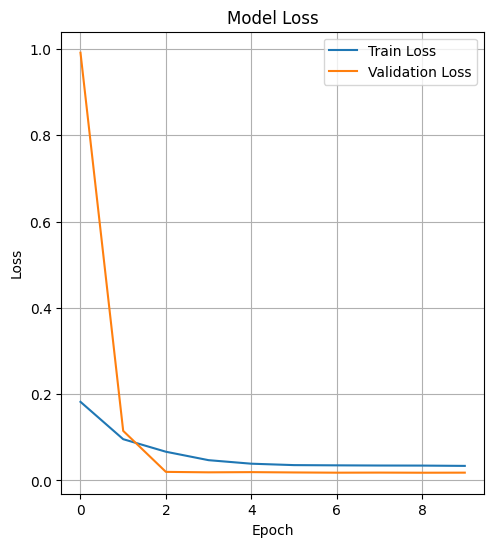

In [ ]:

plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

In [ ]:
print("Shape of train_x_padded before prediction:", train_x_padded.shape)

Shape of train_x_padded before prediction: (23999, 454, 36)


In [ ]:
# Predictions Train


y_pred_prob = model.predict(train_x_padded)
print(y_pred_prob.shape)

y_pred = (y_pred_prob > 0.5).astype("int32")
print(len(y_pred))
predictions_with_patient_ids = []
observed_with_patient_ids = []

for index, row in train_y_grouped.iterrows():
    patient_id = row['patient']
    patient_predictions = y_pred_prob[index]
    for time_step, pred in enumerate(patient_predictions):
        predictions_with_patient_ids.append({'patient': patient_id, 'time_step': time_step, 'prediction': pred})
for index, row in train_y_grouped.iterrows():
    patient_id = row['patient']
    patient_observed = train_y_padded[index]
    for time_step, obs in enumerate(patient_observed):
        observed_with_patient_ids.append({'patient': patient_id, 'time_step': time_step, 'observation': obs})

# Convert to DataFrame
predictions_train_df = pd.DataFrame(predictions_with_patient_ids)
print(predictions_train_df.shape)
observed_train_df = pd.DataFrame(observed_with_patient_ids)
observed_train_df.shape

750/750 [==============================] - 197s 263ms/step
(23999, 454, 1)
23999
(10895546, 3)


(10895546, 3)

In [ ]:
predictions_train_df['prediction'] = predictions_train_df['prediction'].astype('int')

In [ ]:
# Training

cf = confusion_matrix(observed_train_df['observation'],predictions_train_df['prediction'] )
rc  = recall_score(observed_train_df['observation'],predictions_train_df['prediction'] )
pc = precision_score(observed_train_df['observation'],predictions_train_df['prediction'] )
f1 = f1_score(observed_train_df['observation'],predictions_train_df['prediction'] )
ac = accuracy_score(observed_train_df['observation'],predictions_train_df['prediction'] )
print('accuracy_score', ac)
print(cf)
print(rc)
print(pc)
print(f"F1 Score: {f1}")

accuracy_score 0.9818372571691222
[[10554726    43065]
 [  154828   142927]]
0.48001544894292286
0.7684577831304572
F1 Score: 0.5909163260960791


In [ ]:
#predictions Valid

y_pred_prob = model.predict(valid_x_padded)


y_pred = (y_pred_prob > 0.5).astype("int32")
print(len(y_pred))
predictions_with_patient_ids = []
observed_with_patient_ids = []

for index, row in valid_y_grouped.iterrows():
    patient_id = row['patient']
    patient_predictions = y_pred[index]
    for time_step, pred in enumerate(patient_predictions):
        predictions_with_patient_ids.append({'patient': patient_id, 'time_step': time_step, 'prediction': pred})
for index, row in valid_y_grouped.iterrows():
    patient_id = row['patient']
    patient_observed = valid_y_padded[index]
    for time_step, obs in enumerate(patient_observed):
        observed_with_patient_ids.append({'patient': patient_id, 'time_step': time_step, 'observation': obs})

# Convert to DataFrame
predictions_df = pd.DataFrame(predictions_with_patient_ids)
print(predictions_df.shape)
observed_df = pd.DataFrame(observed_with_patient_ids)
observed_df.shape

133/133 [==============================] - 37s 269ms/step
4236
(1923144, 3)


(1923144, 3)

In [ ]:
predictions_df['prediction'] = predictions_df['prediction'].astype('int')

In [ ]:




# Evaluate
cf = confusion_matrix(observed_df['observation'],predictions_df['prediction'] )
rc  = recall_score(observed_df['observation'],predictions_df['prediction'] )
pc = precision_score(observed_df['observation'],predictions_df['prediction'] )
f1 = f1_score(observed_df['observation'],predictions_df['prediction'] )
ac = accuracy_score(observed_df['observation'],predictions_df['prediction'] )

print('accuracy_score', ac)
print(cf)
print(rc)
print(pc)
print(f"F1 Score: {f1}")

accuracy_score 0.9911727878931583
[[1904716   15424]
 [   1552    1452]]
0.4833555259653795
0.08603934581654421
F1 Score: 0.1460764587525151


## 7. Creating a Prediction Data Frame
  - Creating a data frame for the predictions of each patient per time step based on the components of the original data.
  - Sorting the data to match the orignal sequence.
  - Predictiing at the 50% threshold

In [12]:
def predictions(y_pred_prob, sequence, patient_ids, threshold = .5):



  # Binarize predictions
  y_pred = (y_pred_prob > threshold).astype("int32")


  #  predictions per patient
  prob_predictions_with_patient_ids = []
  binary_predictions_with_patient_ids = []


  # Iterate over patients
  for index in range(len(patient_ids)):
      patient_id = patient_ids[index]
      if index < len(y_pred):
          #Sequences
          actual_observations = sequence[index]
          # getting predictions
          binary_patient_predictions = y_pred[index][:len(actual_observations)]
          prob_patient_predictions = y_pred_prob[index][:len(actual_observations)]
          # Append predictions with patient ID and time step
          for time_step, (binary_pred, prob_pred) in enumerate(zip(binary_patient_predictions, prob_patient_predictions)):
            binary_predictions_with_patient_ids.append({
                'ID': f"{patient_id}_{time_step + 1}",
                'patient': patient_id,
                'time_step': time_step,
                'SepsisLabel': binary_pred,
                'probability': prob_pred
            })


  # Convert to DataFrame
  predictions_df = pd.DataFrame(binary_predictions_with_patient_ids)
  return predictions_df

In [13]:
# Prediction for train, valid, and test

y_pred_prob_tr = model.predict(train_x_padded)
y_pred_prob_val = model.predict(valid_x_padded)
y_pred_prob_te = model.predict(test_x_padded)
patient_ids_tr = train_grouped['patient'].tolist()
patient_ids_val = valid_grouped['patient'].tolist()
patient_ids_te = test_grouped['patient'].tolist()

predictions_train = predictions(y_pred_prob_tr, train_y_sequences, patient_ids_tr)
predictions_valid = predictions(y_pred_prob_val, valid_sequences, patient_ids_val)
predictions_test = predictions(y_pred_prob_te, test_sequences, patient_ids_te)

print(predictions_valid.head())
print(predictions_train.head())
print(predictions_test.head())


379/379 [==============================] - 102s 269ms/step
    ID  patient  time_step SepsisLabel     probability
0  1_1        1          0         [0]  [0.0076791253]
1  1_2        1          1         [0]   [0.005851608]
2  1_3        1          2         [0]   [0.005288132]
3  1_4        1          3         [0]   [0.004422836]
4  1_5        1          4         [0]   [0.004011583]
    ID  patient  time_step SepsisLabel     probability
0  2_1        2          0         [0]   [0.008090733]
1  2_2        2          1         [0]   [0.006042113]
2  2_3        2          2         [0]   [0.005205062]
3  2_4        2          3         [0]   [0.004450891]
4  2_5        2          4         [0]  [0.0041816817]
    ID  patient  time_step SepsisLabel     probability
0  1_1        1          0         [0]  [0.0077939625]
1  1_2        1          1         [0]   [0.005637603]
2  1_3        1          2         [0]  [0.0048002396]
3  1_4        1          3         [0]  [0.0039416305]
4  1_5

In [20]:
predictions_train.shape

(1199157, 5)

In [14]:
def sort(predictions_df, scaled_df):
  unique_patients = scaled_df['patient'].drop_duplicates()

  predictions_df['patient'] = pd.Categorical(predictions_df['patient'], categories=unique_patients, ordered=True)

  predictions_df = predictions_df.sort_values(['patient', 'time_step']).reset_index(drop=True)


  predictions_df['SepsisLabel'] = predictions_df['SepsisLabel'].astype('int')
  predictions_df['probability'] = predictions_df['probability'].astype('float')

  return predictions_df

In [15]:
## Sorting to the original sequence

sorted_train = sort(predictions_train, train_x_scaled)
sorted_valid = sort(predictions_valid, valid_x_scaled)
sorted_test = sort(predictions_test, test_x_scaled)

print(sorted_train.head())
print(sorted_valid.head())
print(sorted_test.head())

        ID patient  time_step  SepsisLabel  probability
0  16426_1   16426          0            0     0.007252
1  16426_2   16426          1            0     0.005230
2  16426_3   16426          2            0     0.004542
3  16426_4   16426          3            0     0.003987
4  16426_5   16426          4            0     0.003585
        ID patient  time_step  SepsisLabel  probability
0  11627_1   11627          0            0     0.008221
1  11627_2   11627          1            0     0.006083
2  11627_3   11627          2            0     0.004752
3  11627_4   11627          3            0     0.004057
4  11627_5   11627          4            0     0.003638
       ID patient  time_step  SepsisLabel  probability
0  6560_1    6560          0            0     0.010399
1  6560_2    6560          1            0     0.007577
2  6560_3    6560          2            0     0.007114
3  6560_4    6560          3            0     0.006361
4  6560_5    6560          4            0     0.00609

In [16]:
min_samples = min(len(sorted_train), len(train_y))
sorted_train_df = sorted_train[:min_samples]
y_train_df = train_y[:min_samples]

In [17]:
#Train Metrics

cf_tr = confusion_matrix(y_train_df['SepsisLabel'], sorted_train_df['SepsisLabel'] )
rc_tr  = recall_score(y_train_df['SepsisLabel'], sorted_train_df['SepsisLabel'] )
pc_tr = precision_score(y_train_df['SepsisLabel'],sorted_train_df['SepsisLabel'] )
f1_tr = f1_score(y_train_df['SepsisLabel'],sorted_train_df['SepsisLabel'])
ac_tr = accuracy_score(y_train_df['SepsisLabel'], sorted_train_df['SepsisLabel'])
print('accuracy_score:', ac_tr)
print('confusion matrix:', cf_tr)
print('recall:', rc_tr)
print('precision:' ,pc_tr)
print('f1:' ,f1_tr)

accuracy_score: 0.6599619566078504
confusion matrix: [[737832 164002]
 [243757  53566]]
recall: 0.18016096971979967
precision: 0.2462034858067363
f1: 0.20806733852407597


In [18]:
# Valid Metrics


cf_val = confusion_matrix(valid_y['SepsisLabel'], sorted_valid['SepsisLabel'] )
rc_val  = recall_score(valid_y['SepsisLabel'], sorted_valid['SepsisLabel'] )
pc_val = precision_score(valid_y['SepsisLabel'],sorted_valid['SepsisLabel'] )
f1_val = f1_score(valid_y['SepsisLabel'],sorted_valid['SepsisLabel'])
ac_val = accuracy_score(valid_y['SepsisLabel'],sorted_valid['SepsisLabel'])

print('accuracy_score:', ac_val)
print('confusion matrix:', cf_val)
print('recall:', rc_val)
print('precision:', pc_val)
print('f1:', f1_val)

accuracy_score: 0.8963047609735827
confusion matrix: [[145222  15417]
 [  1552   1452]]
recall: 0.4833555259653795
precision: 0.08607504890627779
f1: 0.1461279122427414


## 8. Threshold Optimization

  - Creating a function to find prediction metrics at thresholds 0-1 increasing by .01
  - Creating a function to return all threshold predictions.

In [72]:
def performance_metrics(Y, Y_hat, threshold = .5):

    ## Classifying for different thresholds

    Y_hat = (Y_hat >= threshold).astype(int)

    # Making sure that each value is 0 or 1
    Y = np.squeeze(Y)
    Y_pred = np.squeeze(Y_hat)

    # Counting for each part of the matrix
    t_pos = np.sum((Y == 1) & (Y_hat == 1))  # True Positives
    t_neg = np.sum((Y == 0) & (Y_hat == 0))  # True Negatives
    f_pos = np.sum((Y == 0) & (Y_hat == 1))  # False Positives
    f_neg = np.sum((Y == 1) & (Y_hat == 0))  # False Negatives


    # Precsion, Recall, and False Positive Rate
    precision = t_pos/(t_pos + f_pos) if (t_pos + f_pos) > 0 else 1
    recall = t_pos/(t_pos+f_neg) if (t_pos + f_pos) > 0 else 0
    f_pos_rate = f_pos/(f_pos+t_neg)
    t_pos_rate = t_pos/(t_pos+f_neg)

    return  precision, recall, f_pos_rate, t_pos_rate

In [73]:
def threshold_predictions(valid_y, pred_val_y):

  thresholds = np.arange(0.0, 1.01, 0.01)


  precisions_valid = []
  recalls_valid= []
  false_positives_rates_valid =[]
  true_positives_rates_valid = []


  ## Computing the metrics for each threshold
  for threshold in thresholds:
          precision_val, recall_val, f_p_val,t_p_val = performance_metrics(valid_y['SepsisLabel'],pred_val_y['probability'], threshold)
          precisions_valid.append(precision_val)
          recalls_valid.append(recall_val)
          false_positives_rates_valid.append(f_p_val)
          true_positives_rates_valid.append(t_p_val)

  return thresholds, precisions_valid, recalls_valid, false_positives_rates_valid, true_positives_rates_valid

In [103]:
thresholds, precisions_valid, recalls_valid, false_positives_rates_valid, true_positives_rates_valid = threshold_predictions(valid_y, sorted_valid)

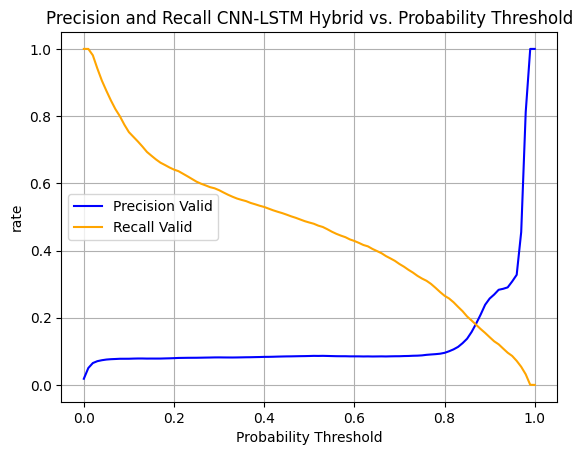

In [104]:


# Plot test Precision, Recall, and false positives
plt.plot(thresholds, precisions_valid, label='Precision Valid', color='blue')
plt.plot(thresholds, recalls_valid, label='Recall Valid', color='orange')


plt.xlabel('Probability Threshold')
plt.ylabel('rate')
plt.title('Precision and Recall CNN-LSTM Hybrid vs. Probability Threshold')
plt.legend()
plt.grid()
plt.show()

In [105]:
precision_recall_diffs_valid = np.abs(np.array(precisions_valid) - np.array(recalls_valid))
sorted_indices_valid = np.argsort(precision_recall_diffs_valid)


print("Thresholds and corresponding precision-recall differences:")
for i, idx in enumerate(sorted_indices_valid[:5]):
    print(f"Threshold: {thresholds[idx]}, Precision: {precisions_valid[idx]}, Recall: {recalls_valid[idx]}, Diff: {precision_recall_diffs_valid[idx]}")

min_diff_index_valid = sorted_indices_valid[0]
closest_threshold_valid = thresholds[min_diff_index_valid]

print('best threshold (valid):', closest_threshold_valid)

Thresholds and corresponding precision-recall differences:
Threshold: 0.87, Precision: 0.18231108098949508, Recall: 0.17909454061251665, Diff: 0.0032165403769784384
Threshold: 0.86, Precision: 0.15763546798029557, Recall: 0.19174434087882822, Diff: 0.03410887289853265
Threshold: 0.88, Precision: 0.20920502092050208, Recall: 0.16644474034620507, Diff: 0.04276028057429701
Threshold: 0.85, Precision: 0.13752808988764045, Recall: 0.20372836218375498, Diff: 0.06620027229611453
Threshold: 0.89, Precision: 0.23858388917393536, Recall: 0.15479360852197072, Diff: 0.08379028065196464
best threshold (valid): 0.87


In [22]:
# Prediction for valid at the optimal threshold

patient_ids_val2 = valid_grouped['patient'].tolist()

predictions_valid2 = predictions(y_pred_prob_val, valid_sequences, patient_ids_val, threshold = .87)

sorted_valid2 = sort(predictions_valid2, valid_x_scaled)


In [152]:


cf_val2 = confusion_matrix(valid_y['SepsisLabel'], sorted_valid2['SepsisLabel'] )
rc_val2  = recall_score(valid_y['SepsisLabel'], sorted_valid2['SepsisLabel'] )
pc_val2 = precision_score(valid_y['SepsisLabel'],sorted_valid2['SepsisLabel'] )
f1_val2 = f1_score(valid_y['SepsisLabel'],sorted_valid2['SepsisLabel'])
ac_val2 = accuracy_score(valid_y['SepsisLabel'],sorted_valid2['SepsisLabel'])

print('accuracy_score:', ac_val2)
print('confusion matrix:', cf_val2)
print('recall:', rc_val2)
print('precision:', pc_val2)
print('f1:', f1_val2)

accuracy_score: 0.9701850980488014
confusion matrix: [[158226   2413]
 [  2466    538]]
recall: 0.17909454061251665
precision: 0.18231108098949508
f1: 0.18068849706129303


## 9. Submission File for Test Data
  - Predict based on the optimal threshold found in the valid data.

In [61]:
patient_ids_te2 = test_grouped['patient'].tolist()

predictions_test2 = predictions(y_pred_prob_te, test_sequences, patient_ids_te, threshold = .87)

sorted_test2 = sort(predictions_test2, test_x_scaled)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
sorted_test2.to_csv('/content/drive/MyDrive/test_matrix.csv', index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
final_test = sorted_test2.drop(columns = ['patient', 'time_step', 'probability'])


In [50]:
final_test.head()

,ID,SepsisLabel
0,6560_1,0
1,6560_2,0
2,6560_3,0
3,6560_4,0
4,6560_5,0


In [63]:
print(final_test['SepsisLabel'].value_counts())
final_test.shape

SepsisLabel
0    456454
1      7900
Name: count, dtype: int64


(464354, 2)

In [ ]:

drive.mount('/content/drive')
final_test.to_csv('/content/drive/MyDrive/submission.csv', index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 10 Ensemble Model Optimization

  - Importing LightGBM output probabilities on the valid data to create and optimize Ensemble model based on the valid data.


In [84]:

uploaded = files.upload()

Saving lightGBM_submission5.csv to lightGBM_submission5.csv


In [85]:
boostprobs = pd.read_csv('lightGBM_submission5.csv')

In [91]:
boostprobs[['ID', 'SepsisLabel']] = boostprobs['ID,SepsisLabel'].str.split(',', expand=True)

boostprobs['probability'] = boostprobs['SepsisLabel'].astype(float)


In [94]:
weighted_probs = .6*sorted_valid2['probability'] + .4*boostprobs['probability']

In [95]:
weighted_probs = pd.DataFrame(weighted_probs, columns = ['probability'])
print(weighted_probs.shape)



(163643, 1)


In [146]:
thresholds_e, precisions_valid_e, recalls_valid_e, false_positives_rates_valid_e, true_positives_rates_valid_e= threshold_predictions(valid_y, weighted_probs)

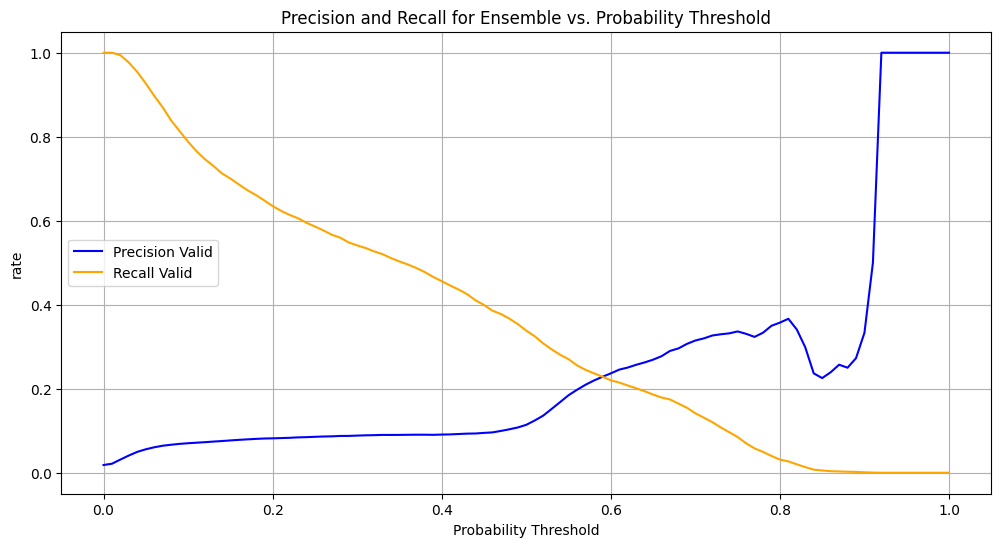

In [147]:
plt.figure(figsize=(12, 6))


# Plot test Precision, Recall, and false positives
plt.plot(thresholds_e, precisions_valid_e, label='Precision Valid', color='blue')
plt.plot(thresholds_e, recalls_valid_e, label='Recall Valid', color='orange')


plt.xlabel('Probability Threshold')
plt.ylabel('rate')
plt.title('Precision and Recall for Ensemble vs. Probability Threshold')
plt.legend()
plt.grid()
plt.show()

In [154]:
precision_recall_diffs_valid = np.abs(np.array(precisions_valid_e) - np.array(recalls_valid_e))
sorted_indices_valid = np.argsort(precision_recall_diffs_valid)


print("Thresholds and corresponding precision-recall differences:")
for i, idx in enumerate(sorted_indices_valid[:5]):
    print(f"Threshold: {thresholds_e[idx]}, Precision: {precisions_valid_e[idx]}, Recall: {recalls_valid_e[idx]}, Diff: {precision_recall_diffs_valid[idx]}")

min_diff_index_valid = sorted_indices_valid[0]
closest_threshold_valid = thresholds_e[min_diff_index_valid]

print('best threshold (valid):', closest_threshold_valid)

Thresholds and corresponding precision-recall differences:
Threshold: 0.59, Precision: 0.22831505483549352, Recall: 0.22869507323568575, Diff: 0.00038001840019222244
Threshold: 0.6, Precision: 0.23657838224767358, Recall: 0.2200399467376831, Diff: 0.016538435509990485
Threshold: 0.58, Precision: 0.21957998764669548, Recall: 0.2366844207723036, Diff: 0.01710443312560811
Threshold: 0.61, Precision: 0.24552721735820326, Recall: 0.21471371504660453, Diff: 0.03081350231159874
Threshold: 0.5700000000000001, Precision: 0.20932878270762229, Recall: 0.24500665778961384, Diff: 0.03567787508199155
best threshold (valid): 0.59


In [157]:
## Ensemble Performance Metrics


y_pred_boost = (weighted_probs >= .6).astype("int32")
cf_val3 = confusion_matrix(valid_y['SepsisLabel'], y_pred_boost )
rc_val3  = recall_score(valid_y['SepsisLabel'], y_pred_boost )
pc_val3 = precision_score(valid_y['SepsisLabel'],y_pred_boost )
f1_val3 = f1_score(valid_y['SepsisLabel'],y_pred_boost)
ac_val3 = accuracy_score(valid_y['SepsisLabel'],y_pred_boost)

print('accuracy_score:', ac_val3)
print('confusion matrix:', cf_val3)
print('recall:', rc_val3)
print('precision:', pc_val3)
print('f1:', f1_val3)

accuracy_score: 0.9726477759513087
confusion matrix: [[158506   2133]
 [  2343    661]]
recall: 0.2200399467376831
precision: 0.23657838224767358
f1: 0.22800965850293203


## 11. ROC Curves and Precision Recall Curves for Each Model

In [113]:
thresholds_g, precisions_valid_g, recalls_valid_g, false_positives_rates_valid_g, true_positives_rates_valid_g= threshold_predictions(valid_y, boostprobs)

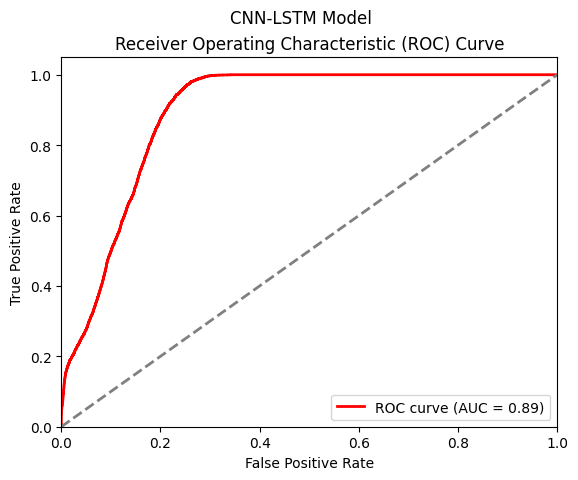

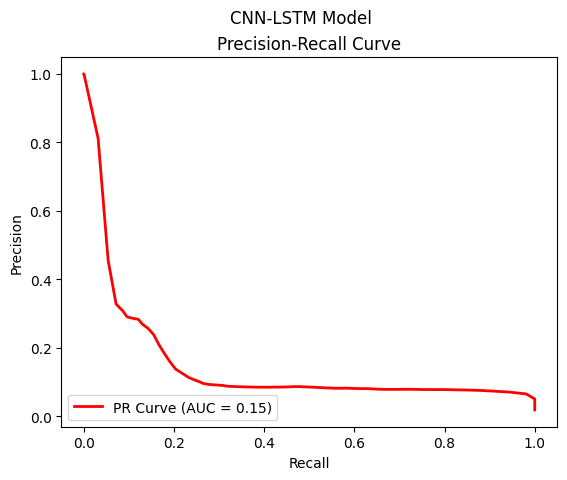

In [134]:
## CNN-LSTM Valid ROC curve

fpr_c, tpr_c, thresholds = roc_curve(valid_y['SepsisLabel'], sorted_valid2['probability'])
roc_auc_c = auc(fpr_c, tpr_c)

plt.figure()
plt.plot(fpr_c, tpr_c, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc_c:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.suptitle('CNN-LSTM Model')
plt.legend(loc="lower right")
plt.show()




pr_auc_c = auc(recalls_valid, precisions_valid)


plt.figure()
plt.plot(recalls_valid, precisions_valid, color='red', lw=2, label=f'PR Curve (AUC = {pr_auc_c:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.suptitle('CNN-LSTM Model')
plt.legend(loc="lower left")
plt.show()

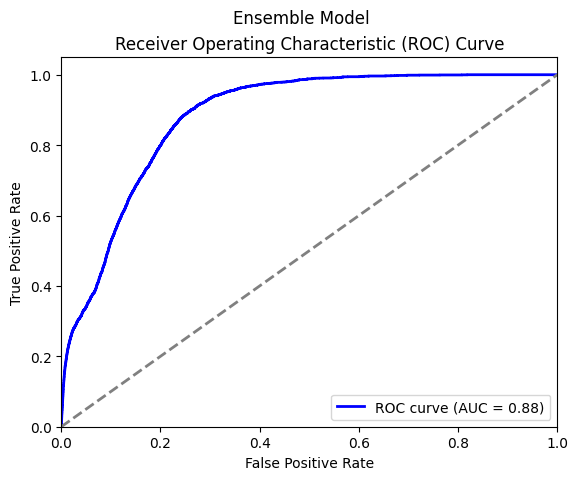

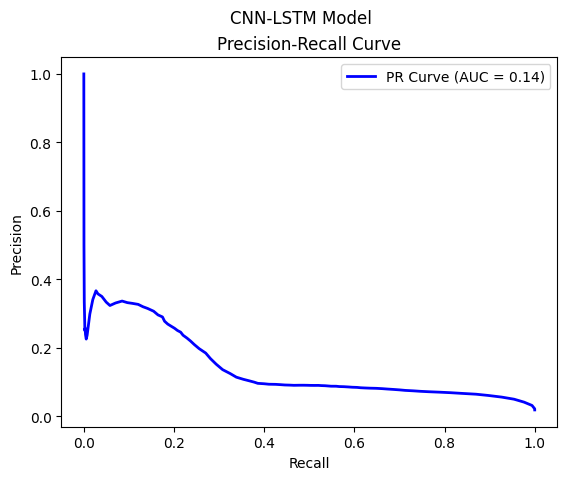

In [160]:
## Ensemble Valid ROC curve Precision Recall Curve

fpr_e, tpr_e, thresholds = roc_curve(valid_y['SepsisLabel'], weighted_probs['probability'])
roc_auc_e = auc(fpr_e, tpr_e)

plt.figure()
plt.plot(fpr_e, tpr_e, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_e:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.suptitle('Ensemble Model')
plt.legend(loc="lower right")
plt.show()


pr_auc_e = auc(recalls_valid_e, precisions_valid_e)


plt.figure()
plt.plot(recalls_valid_e, precisions_valid_e, color='blue', lw=2, label=f'PR Curve (AUC = {pr_auc_e:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.suptitle('CNN-LSTM Model')
plt.legend(loc="upper right")
plt.show()

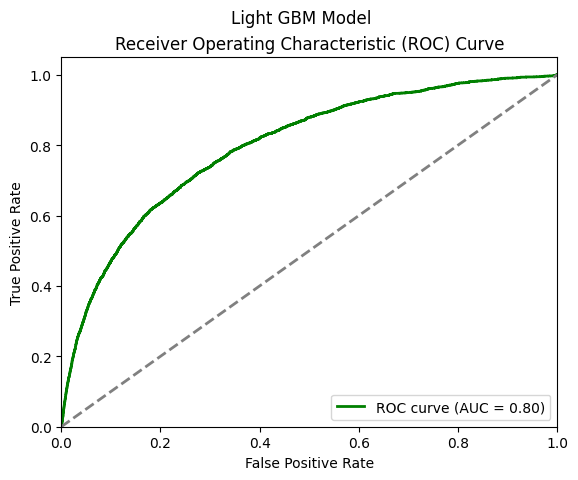

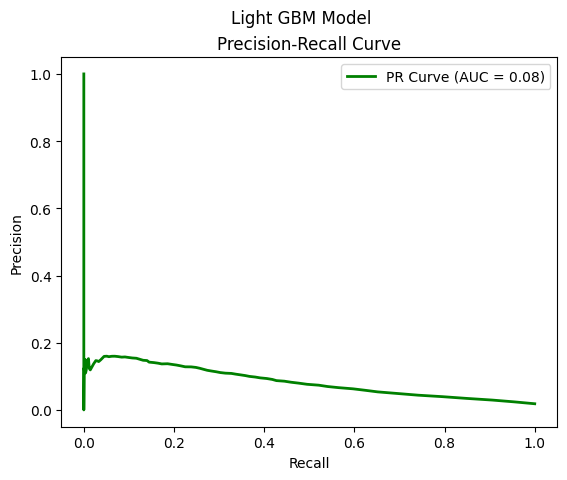

In [159]:
## LightGBM Valid ROC curve

fpr_gbm, tpr_gbm, thresholds = roc_curve(valid_y['SepsisLabel'], boostprobs['probability'])
roc_auc_g = auc(fpr_gbm, tpr_gbm)

plt.figure()
plt.plot(fpr_gbm, tpr_gbm, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc_g:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.suptitle('Light GBM Model')
plt.legend(loc="lower right")
plt.show()




pr_auc_g = auc(recalls_valid_g, precisions_valid_g)


plt.figure()
plt.plot(recalls_valid_g, precisions_valid_g, color='green', lw=2, label=f'PR Curve (AUC = {pr_auc_g:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.suptitle('Light GBM Model')
plt.legend(loc="upper right")
plt.show()

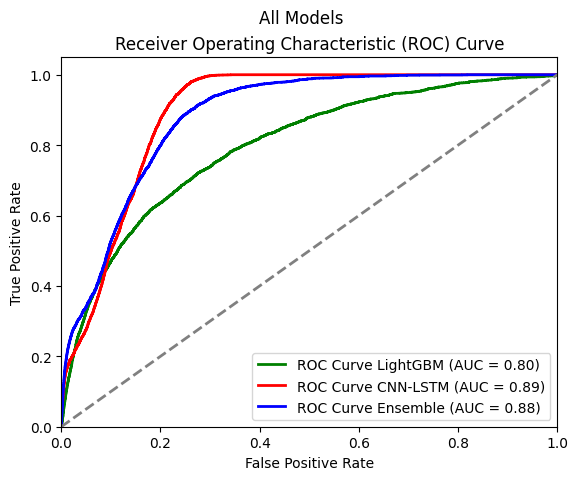

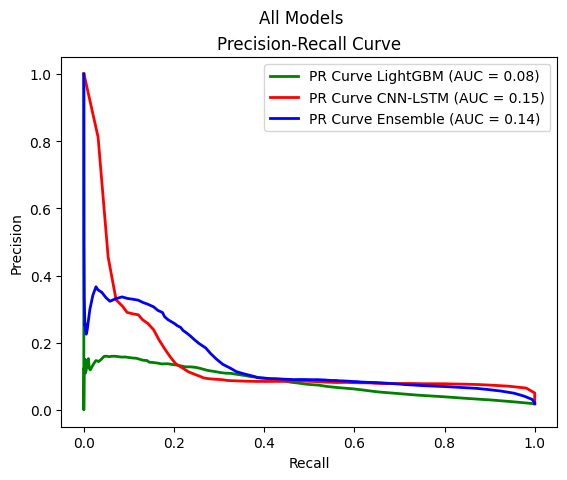

In [142]:
plt.figure()
plt.plot(fpr_gbm, tpr_gbm, color='green', lw=2, label=f'ROC Curve LightGBM (AUC = {roc_auc_g:.2f})')
plt.plot(fpr_c, tpr_c, color='red', lw=2, label=f'ROC Curve CNN-LSTM (AUC = {roc_auc_c:.2f})')
plt.plot(fpr_e, tpr_e, color='blue', lw=2, label=f'ROC Curve Ensemble (AUC = {roc_auc_e:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.suptitle('All Models')
plt.legend(loc="lower right")
plt.show()



plt.figure()
plt.plot(recalls_valid_g, precisions_valid_g, color='green', lw=2, label=f'PR Curve LightGBM (AUC = {pr_auc_g:.2f})')
plt.plot(recalls_valid, precisions_valid, color='red', lw=2, label=f'PR Curve CNN-LSTM (AUC = {pr_auc_c:.2f})')
plt.plot(recalls_valid_e, precisions_valid_e, color='blue', lw=2, label=f'PR Curve Ensemble (AUC = {pr_auc_e:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.suptitle('All Models')
plt.legend(loc="upper right")
plt.show()